[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/YuichiKZ/pytorch_gan/blob/main/Section6_ConditionalGAN_MNIST_pytorch.ipynb)

#ConditionalGANのノートブック
- このノートブックではPyTorchによるConditionalGANネットワークの実装と学習を行います。

#学習目標
- 画像を生成するGenerator(生成器)のネットワーク構造を理解する
- 画像を識別するDiscriminator(識別器)のネットワーク構造を理解する
- ConditionalGANの損失関数とニューラルネットワークの学習の流れを理解する
- ConditionalGANの入力ラベルベクトルについて理解する
- ConditionalGANのネットワークを実装できるようにする


# GPU確認

In [1]:
!nvidia-smi

Mon May  9 14:49:16 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    23W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# PyTorch インポート & バージョン確認

In [2]:
import torch
import torchvision
# バージョンの確認
print(torch.__version__) 
print(torchvision.__version__) 

1.11.0+cu113
0.12.0+cu113


# ConditionalGAN実装

## パッケージインポート

In [3]:
# パッケージのインポート
import os
import random
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import torchsummary

## パラメータ設定

In [4]:
batch_size=50
z_dim = 100 #ノイズ次元
g_dim = 128 
d_dim = 128 
num_epochs = 10 #エポック数
lr = 0.0002
beta1 = 0.5
out_dir = './result_4-CGAN'
loss_display_interval = 600

# 保存先ディレクトリを作成
try:
    os.makedirs(out_dir, exist_ok=True)
except Exception as error: 
    print(error)

# 乱数のシード（種）を固定
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

##データセット定義

- `transforms.Compose(transforms)`
<br>
複数の Transform を連続して行う Transform を作成
- `transforms.ToTensor()`
<br>
PIL Imageまたはnumpy ndarrayをTorch Tensorに変換
- `transforms.Normalize((mean,...),(std,...))`
<br>
各チャンネルに関して標準化を行う<br>
$output[channel] = (input[channel]-mean[channel])/std[channel]$
<br>
i.e. <br>
MNISTの場合<br>
チャンネル数: 1(白黒画像)<br>
分布: [0,1]<br>
より
$std=0.5, mean=0.5$とすると
分布は[-1,1]となる。

In [5]:
# MNISTの訓練データセットを読み込む
# transforms.ToTensor()-> Torch Tensorに変換
# transforms.Normalize((mean,),(std)) -> テンソルの値を平均0
dataset = dset.MNIST(root='./mnist_data', download=True, train=True,
                      transform=transforms.Compose([
                          transforms.ToTensor(),
                          transforms.Normalize((0.5,), (0.5,)) ]))

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



In [6]:
# 画像配列の形状確認
dataset[0][0].shape

torch.Size([1, 28, 28])

In [7]:
# 訓練データをセットしたDataLoader作成
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True)

# 学習に使用するデバイスを指定。
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('device:', device)

device: cuda:0


##ネットワークの定義

### Generatorクラス

In [8]:
class Generator(nn.Module):
    def __init__(self, z_dim=100, g_dim=128, nch=1):
        """
        z_dim: 入力ベクトルzの次元
        g_dim: 最終層の入力チャネル数
        nch: 出力画像のチャネル数
        """
        super(Generator, self).__init__()

        # ニューラルネットワークの構造を定義する
        self.layer0 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels = z_dim,
                out_channels = g_dim * 4,
                kernel_size = 3,
                stride = 1,
                padding = 0
            ),     # 転置畳み込み
            nn.BatchNorm2d(g_dim * 4),                      # バッチノーマライゼーション
            nn.ReLU()                                       # ReLU
        )  # (B, z_dim, 1, 1) -> (B, g_dim*4, 3, 3)

        self.layer1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels = g_dim * 4,
                               out_channels = g_dim * 2, 
                               kernel_size = 3, 
                               stride = 2, 
                               padding = 0
            ),     # 転置畳み込み
            nn.BatchNorm2d(g_dim * 2),
            nn.ReLU()
        )  # (B, g_dim*4, 3, 3) -> (B, g_dim*2, 7, 7)

        self.layer2 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels = g_dim * 2, 
                out_channels = g_dim, 
                kernel_size = 4, 
                stride = 2, 
                padding = 1
            ),
            nn.BatchNorm2d(g_dim),
            nn.ReLU()
        )  # (B, g_dim*2, 7, 7) -> (B, g_dim, 14, 14)

        self.layer3 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels = g_dim, 
                out_channels = nch, 
                kernel_size = 4, 
                stride = 2, 
                padding = 1
            ),
            nn.Tanh()
        )  # (B, g_dim, 14, 14) -> (B, nch, 28, 28)

        self.layers = [self.layer0,
                       self.layer1,
                       self.layer2,
                       self.layer3]

    def forward(self, z):
        """
        順方向の演算
        z: 入力ノイズ
        return z: 生成画像
        """
        for layer in self.layers:  # self.layersの各層で演算を行う
            z = layer(z)
        return z

### Discriminatorクラス

In [9]:
class Discriminator(nn.Module):
    """
    識別器Dのクラス
    """
    def __init__(self, nch=1, d_dim=128):
        """
        nch: 入力画像のチャネル数
        d_dim: 先頭層の出力チャネル数
        """
        super(Discriminator, self).__init__()

        # ニューラルネットワークの構造を定義する
        self.layer0 = nn.Sequential(
                nn.Conv2d(nch, d_dim, 4, 2, 1),     # 畳み込み
                nn.LeakyReLU(negative_slope=0.2)    # leaky ReLU関数
            )  # (B, nch, 28, 28) -> (B, d_dim, 14, 14)
        self.layer1 = nn.Sequential(
                nn.Conv2d(d_dim, d_dim * 2, 4, 2, 1),
                nn.BatchNorm2d(d_dim * 2),
                nn.LeakyReLU(negative_slope=0.2)
            )
        self.layer2 = nn.Sequential(
                nn.Conv2d(d_dim * 2, d_dim * 4, 3, 2, 0),
                nn.BatchNorm2d(d_dim * 4),
                nn.LeakyReLU(negative_slope=0.2)
            )  # (B, d_dim*2, 7, 7) -> (B, d_dim*4, 3, 3)
        self.layer3 = nn.Sequential(
                nn.Conv2d(d_dim * 4, 1, 3, 1, 0),
                nn.Sigmoid()    # Sigmoid関数
            )    # (B, d_dim*4, 3, 3) -> (B, 1, 1, 1)
        self.layers =[self.layer0,
                      self.layer1,
                      self.layer2,
                      self.layer3]

    def forward(self, x):
        """
        順方向演算
        x: 本物画像または生成画像
        return: 識別信号
        """
        for layer in self.layers:  # self.layersの各層で演算を行う
            x = layer(x)
        return x.squeeze()     # Tensorの形状を(B,1,1,1)->(B)に変更して戻り値とする

### 重み初期化関数

In [10]:
def weights_init(m):
    """
    ニューラルネットワークの重みを初期化する。作成したインスタンスに対しapplyメソッドで適用する
    m: ニューラルネットワークを構成する層
    """
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:            # 畳み込み層の場合
        m.weight.data.normal_(0.0, 0.02)
        m.bias.data.fill_(0)
    elif classname.find('Linear') != -1:        # 全結合層の場合
        m.weight.data.normal_(0.0, 0.02)
        m.bias.data.fill_(0)
    elif classname.find('BatchNorm') != -1:     # バッチノーマライゼーションの場合
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

### 生成器Gのインスタンス生成と重み初期化

In [11]:
# 生成器G　インスタンス化, GPU上に転送
G = Generator(z_dim=z_dim+10, g_dim=g_dim).to(device) #10はn_class=10を指す。出し分けに必要なラベル情報
G.apply(weights_init)    # weights_init関数で初期化

Generator(
  (layer0): Sequential(
    (0): ConvTranspose2d(110, 512, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer1): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer2): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer3): Sequential(
    (0): ConvTranspose2d(128, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): Tanh()
  )
)

In [12]:
# 生成器GのTensor形状
# 100次元のランダムノイズと10次元のクラスラベルをconcatしたものを入力とする
torchsummary.summary(G, (110, 1, 1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 3, 3]         507,392
       BatchNorm2d-2            [-1, 512, 3, 3]           1,024
              ReLU-3            [-1, 512, 3, 3]               0
   ConvTranspose2d-4            [-1, 256, 7, 7]       1,179,904
       BatchNorm2d-5            [-1, 256, 7, 7]             512
              ReLU-6            [-1, 256, 7, 7]               0
   ConvTranspose2d-7          [-1, 128, 14, 14]         524,416
       BatchNorm2d-8          [-1, 128, 14, 14]             256
              ReLU-9          [-1, 128, 14, 14]               0
  ConvTranspose2d-10            [-1, 1, 28, 28]           2,049
             Tanh-11            [-1, 1, 28, 28]               0
Total params: 2,215,553
Trainable params: 2,215,553
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forw

In [13]:
# 識別器D　インスタンス化, GPU上に転送, 画像が本物か生成かを識別する
# 画像と10クラスのラベルをconcatしたものを合わせたものを入力する
D = Discriminator(nch=1+10, d_dim=d_dim).to(device) #10はn_class=10を指す。分類に必要なラベル情報
D.apply(weights_init)

Discriminator(
  (layer0): Sequential(
    (0): Conv2d(11, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
  )
  (layer1): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (layer2): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (layer3): Sequential(
    (0): Conv2d(512, 1, kernel_size=(3, 3), stride=(1, 1))
    (1): Sigmoid()
  )
)

In [14]:
# 識別器DのTensor形状
torchsummary.summary(D, (11, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 14, 14]          22,656
         LeakyReLU-2          [-1, 128, 14, 14]               0
            Conv2d-3            [-1, 256, 7, 7]         524,544
       BatchNorm2d-4            [-1, 256, 7, 7]             512
         LeakyReLU-5            [-1, 256, 7, 7]               0
            Conv2d-6            [-1, 512, 3, 3]       1,180,160
       BatchNorm2d-7            [-1, 512, 3, 3]           1,024
         LeakyReLU-8            [-1, 512, 3, 3]               0
            Conv2d-9              [-1, 1, 1, 1]           4,609
          Sigmoid-10              [-1, 1, 1, 1]               0
Total params: 1,733,505
Trainable params: 1,733,505
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.03
Forward/backward pass size (MB): 0.78
Params size (MB): 6.61
Estimat

##ネットワークの定義

## 学習の実行

In [15]:
criterion = nn.BCELoss()    # バイナリークロスエントロピー

# 生成器のエポックごとの画像生成に使用する確認用の固定ノイズ
fixed_noise = torch.randn(batch_size, z_dim, 1, 1, device=device)  

# オプティマイザの用意
optimizerD = optim.Adam(D.parameters(), lr=lr, betas=(beta1, 0.999), weight_decay=1e-5)  # 識別器D用
optimizerG = optim.Adam(G.parameters(), lr=lr, betas=(beta1, 0.999), weight_decay=1e-5)  # 生成器G用

## onehotラベルの生成

- Step1: 単位行列の作成<br>
`torch.eye(n,m=None)`<br>
parameters: クラスの次元<br>
n : 行数,
m : 列数(default, m=n)<br>
output: n行m列の単位行列
\begin{bmatrix}
  1       & 0     & 0  & 0 \\
  0       & 1     & 0  & 0 \\
  \vdots  & \vdots  & \cdots & \vdots    \\
  0       & 0      & \dots  & 1
\end{bmatrix}

- Step2: 単位行列のラベルとなる行を取り出しonehotラベルを作成



In [16]:
def onehot_encode(label, device, n_class=10):
    """
    カテゴリカル変数のラベルをOne-Hot形式に変換する
    label: 変換対象のラベル
    device: 学習に使用するデバイス。CPUあるいはGPU
    n_class: ラベルのクラス数
    return:
    """
    eye = torch.eye(n_class, device=device)
    # ランダムベクトルあるいは画像と連結するために(B, c_class, 1, 1)のTensorにして戻す
    return eye[label].view(-1, n_class, 1, 1) 

### 画像とラベルの連結

- Step1<br>
カテゴリカル変数をonehotラベルに変換<br>
前段で定義した`onehot_encode()`を用いる<br>
例:<br>
0: [1,0,0,0,0,0,0,0,0,0] <br>
1: [0,1,0,0,0,0,0,0,0,0] <br>
... <br>
9: [0,0,0,0,0,0,0,0,0,1] <br>

- Step2<br>
Step1で作成したonehotラベルをMNIST画像テンソル(BATCH_SIZE, 1, 28, 28)と結合できる形状に変換する。<br>
`torch.expand()`を用いて<br>
(BATCH_SIZE, 10, 1, 1) -> (BATCH_SIZE, 10, 28, 28)
に拡張する。

- Step3<br>
Step2で作成した<br>
ラベルテンソル(BATCH_SIZE, 10, 28, 28)と<br>
MNIST画像テンソル(BATCH_SIZE, 1, 28, 28)を<br>
`torch.cat((img,label),dim)`
で結合する。結合する次元は1。

In [17]:
def concat_image_label(image, label, device, n_class=10):
    """
    image:　画像
    label: ラベル
    device: 学習に使用するデバイス。CPUまたはGPU
    n_class: ラベルのクラス数
    return:　画像とラベルをChannel方向に連結したTensor
    """
    B, C, H, W = image.shape    # 画像Tensorの大きさを取得
    
    onehot_label = onehot_encode(label, device)         # ラベルをOne-Hotベクトル化
    onehot_label = onehot_label.expand(B, n_class, H, W)    # 画像のサイズに合わせるようラベルを拡張する
    return torch.cat((image, onehot_label), dim=1)      # 画像とラベルをチャネル方向（dim=1）で連結する

### ノイズとラベルの連結
- Step1<br>
カテゴリカル変数をonehotラベルに変換<br>
前段で定義した`onehot_encode()`を用いる<br>
例:<br>
0: [1,0,0,0,0,0,0,0,0,0] <br>
1: [0,1,0,0,0,0,0,0,0,0] <br>
... <br>
9: [0,0,0,0,0,0,0,0,0,1] <br>
- Step2<br>
noise: (BATCH_SIZE,100,1,1)と<br>
onehotラベル: (BATCH_SIZE,10,1,1)を連結


In [18]:
def concat_noise_label(noise, label, device):
    """
    noise: ノイズ
    label: ラベル
    device: 学習に使用するデバイス。CPUあるいはGPU
    return:　ノイズとラベルを連結したTensor
    """
    onehot_label = onehot_encode(label, device)     # ラベルをOne-Hotベクトル化
    return torch.cat((noise, onehot_label), dim=1)  # ノイズとラベルをチャネル方向（dim=1）で連結する

In [19]:
# 生成器のエポックごとの画像生成に使用する確認用の固定ノイズ
fixed_noise = torch.randn(batch_size, z_dim, 1, 1, device=device) 
# 確認用のラベル。0-9のラベルの繰り返し
fixed_label = [i for i in range(10)] * (batch_size // 10)
fixed_label = torch.tensor(fixed_label, dtype=torch.long, device=device)
# 確認用のノイズとラベルを連結
fixed_noise_label = concat_noise_label(fixed_noise, fixed_label, device) 
print(fixed_noise.shape)
print(fixed_label)
print(fixed_noise_label.shape)

torch.Size([50, 100, 1, 1])
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3,
        4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7,
        8, 9], device='cuda:0')
torch.Size([50, 110, 1, 1])


In [20]:
G_losses = []
D_losses = []

#最初の画像の保存
fake_image = G(fixed_noise_label)
vutils.save_image(fake_image.detach(), '{}/fake_samples_epoch_{:03d}.png'.format(out_dir, 0),
                      normalize=True, nrow=10)

# 学習のループ
for epoch in range(num_epochs):
    for n, data in enumerate(dataloader):
        real_image = data[0].to(device)     # 本物画像
        real_label = data[1].to(device)     # 本物画像に対応するラベル
        # 本物画像とラベルを連結
        real_image_label = concat_image_label(real_image, real_label, device) 
        sample_size = real_image.size(0)    # 画像枚数

        # 標準正規分布(平均:0,分散:1)からノイズを生成
        noise = torch.randn(sample_size, z_dim, 1, 1, device=device)
        # 生成画像生成用のラベル
        fake_label = torch.randint(10, (sample_size,), dtype=torch.long, device=device)
        # ノイズとラベルを連結
        fake_noise_label = concat_noise_label(noise, fake_label, device)        
        # 本物画像に対する正解ラベル:1 , GPU上に転送
        real_target = torch.full((sample_size,), 1., device=device)
        # 生成画像に対する正解ラベル:0 , GPU上に転送
        fake_target = torch.full((sample_size,), 0., device=device)
        
        """
        識別器Dの更新
        """
        D.zero_grad()    # 勾配の初期化

        ########################
        # 本物画像に対する損失計算
        ########################        
        output = D(real_image_label) # 識別器Dで本物画像とラベルの組み合わせに対する識別信号を出力
        lossD_real = criterion(output, real_target) # 本物画像に対する識別信号の損失値


        ########################
        # 偽物画像に対する損失計算
        ########################
        fake_image = G(fake_noise_label)  # 生成器Gでラベルに対応した生成画像を生成        
        fake_image_label = concat_image_label(fake_image, fake_label, device)   # 生成画像とラベルを連結
        
        output = D(fake_image_label.detach()) # 識別器Dで本物画像に対する識別信号を出力        
        lossD_fake = criterion(output, fake_target)  # 生成画像に対する識別信号の損失値

        ########################
        # 損失計算し,誤差逆伝播
        ########################
        lossD = lossD_real + lossD_fake    # 識別器Dの全体の損失
        lossD.backward()    # 誤差逆伝播
        optimizerD.step()   # Dのパラメーターを更新

        """
        生成器Gの更新
        """
        G.zero_grad()    # 勾配の初期化
        
        output = D(fake_image_label)     # 更新した識別器Dで改めて生成画像とラベルの組み合わせに対する識別信号を出力
        lossG = criterion(output, real_target)   # 生成器Gの損失値。Dに生成画像を本物画像と誤認させたいため目標値は「1」
        lossG.backward()     # 誤差逆伝播

        optimizerG.step()   # Gのパラメータを更新

        """
        DとGのロス表示
        """
        if n % loss_display_interval == 0: 
            print('epoch:[{}/{}],num_images:[{}/{}] Loss_D: {:.3f} Loss_G: {:.3f}'
                  .format(epoch + 1, num_epochs,
                          n + 1, len(dataloader),
                          lossD.item(), lossG.item()))
            
        if epoch == 0 and n == 0:     # 初回に本物画像を保存する
            vutils.save_image(real_image, '{}/real_samples.png'.format(out_dir),
                              normalize=True, nrow=10)

        # ログ出力用データの保存
        D_losses.append(lossD.item())
        G_losses.append(lossG.item())

    """
    確認用画像の生成
    """
    fake_image = G(fixed_noise_label)  # 1エポック終了ごとに確認用の生成画像を生成する
    vutils.save_image(fake_image.detach(), '{}/fake_samples_epoch_{:03d}.png'.format(out_dir, epoch + 1),
                      normalize=True, nrow=10)

    """
    モデルの保存
    """
    if (epoch + 1) % 10 == 0:   # 10エポックごとにモデルを保存する
        torch.save(G.state_dict(), '{}/G_epoch_{}.pth'.format(out_dir, epoch + 1))
        torch.save(D.state_dict(), '{}/D_epoch_{}.pth'.format(out_dir, epoch + 1))

epoch:[1/10],num_images:[1/1200] Loss_D: 1.429 Loss_G: 1.731
epoch:[1/10],num_images:[601/1200] Loss_D: 0.757 Loss_G: 2.044
epoch:[2/10],num_images:[1/1200] Loss_D: 1.489 Loss_G: 1.001
epoch:[2/10],num_images:[601/1200] Loss_D: 0.944 Loss_G: 1.318
epoch:[3/10],num_images:[1/1200] Loss_D: 1.129 Loss_G: 1.802
epoch:[3/10],num_images:[601/1200] Loss_D: 1.485 Loss_G: 0.980
epoch:[4/10],num_images:[1/1200] Loss_D: 1.288 Loss_G: 1.050
epoch:[4/10],num_images:[601/1200] Loss_D: 1.165 Loss_G: 1.106
epoch:[5/10],num_images:[1/1200] Loss_D: 0.962 Loss_G: 1.472
epoch:[5/10],num_images:[601/1200] Loss_D: 1.060 Loss_G: 1.246
epoch:[6/10],num_images:[1/1200] Loss_D: 1.552 Loss_G: 1.007
epoch:[6/10],num_images:[601/1200] Loss_D: 0.647 Loss_G: 2.086
epoch:[7/10],num_images:[1/1200] Loss_D: 1.239 Loss_G: 0.773
epoch:[7/10],num_images:[601/1200] Loss_D: 1.165 Loss_G: 1.303
epoch:[8/10],num_images:[1/1200] Loss_D: 1.324 Loss_G: 1.189
epoch:[8/10],num_images:[601/1200] Loss_D: 0.989 Loss_G: 1.400
epoch:[9

### 学習済みモデルの推論画像表示

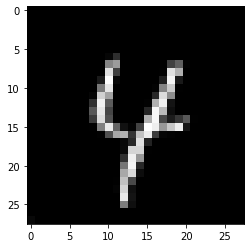

In [28]:
from PIL import Image

number = '4' #@param [0,1,2,3,4,5,6,7,8,9] {allow-input: true}
number = int(number) #int型に変換

# 標準正規分布(平均:0,分散:1)からノイズを生成
noise = torch.randn(sample_size, z_dim, 1, 1, device=device)
# 生成画像生成用のラベル
fake_label = torch.full((sample_size,),number, dtype=torch.long, device=device)
# ノイズとラベルを連結
fake_noise_label = concat_noise_label(noise, fake_label, device)

fake_image = G(fake_noise_label) # 生成器Gでノイズから生成画像を生成
fake_image = fake_image.to('cpu').detach() #Pytorch TensorをGPUからCPUに転送
fake_image = fake_image.numpy() #numpy arrayに変換
fake_image = fake_image.squeeze() #(B,C,H,W) -> (B,H,W)に変換

plt.imshow(fake_image[0],cmap='gray')

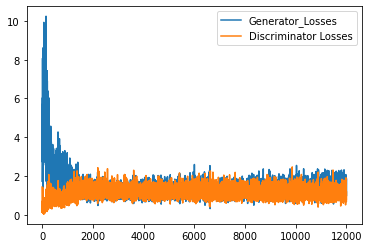

In [29]:
from matplotlib import pyplot as plt

plt.plot(G_losses, label='Generator_Losses')
plt.plot(D_losses, label='Discriminator Losses')
plt.legend()
plt.savefig('loss.png')

### 学習過程のアニメーション

In [23]:
from PIL import Image, ImageDraw

images = []

for epoch in range(num_epochs+1):
  img = Image.open('{}/fake_samples_epoch_{:03d}.png'.format(out_dir, epoch))
  images.append(img)

images[0].save('/content/mnist_cgan_animation.gif',
               save_all=True, append_images=images[1:], optimize=False, duration=200, loop=0)

## 重みのロード & 推論

In [24]:
model_path = os.path.join(out_dir,"G_epoch_10.pth")

# 生成器G　ランダムベクトルから生成画像を作成する
G_infer = Generator(z_dim=z_dim+10, g_dim=g_dim).to(device)  #10はn_class=10を指す。
G_infer.load_state_dict(torch.load(model_path))

# 生成器ごとの画像生成に使用する確認用の固定ノイズ
fixed_noise = torch.randn(batch_size, z_dim, 1, 1, device=device) 
# 確認用のラベル。0-9のラベルの繰り返し
fixed_label = [i for i in range(10)] * (batch_size // 10)
fixed_label = torch.tensor(fixed_label, dtype=torch.long, device=device)
# 確認用のノイズとラベルを連結
fixed_noise_label = concat_noise_label(fixed_noise, fixed_label, device) 

fake_image = G_infer(fixed_noise_label)  #確認用の画像を生成する
vutils.save_image(fake_image.detach(), '{}/Generator_sample.png'.format(out_dir),
                  normalize=True, nrow=10)